ConvLSTM

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,LSTM,Bidirectional,Flatten,TimeDistributed,ConvLSTM2D
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from datetime import datetime
import sys

from read_files import read_files

import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from itertools import product
import warnings
warnings.filterwarnings('ignore')
#%matplotlib inline

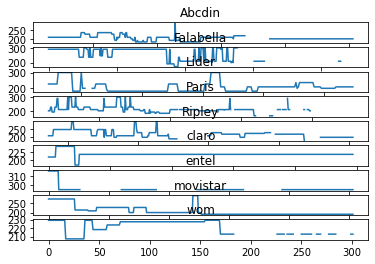

In [2]:
path = "C:/Users/Vasco/OneDrive - Universidade de Aveiro/Grupo/AIA/" #o teu path
path = "C:/Users/Vasco Costa/OneDrive - Universidade de Aveiro/Grupo/AIA/" #o teu path
path = "C:\\Users\\Tiago\\Universidade de Aveiro\Vasco Costa - AIA\\"

product_group_id = 958 #depende da pasta
time_series_folder = 1 #1,2,3

df_long, df_wide = read_files(path,product_group_id,time_series_folder)
product_information = pd.read_pickle(path+"Data/product_information")
#print(product_information.loc[product_group_id])
#print(df_wide)
#print(df_wide.columns)
i = 1
plt.figure()
for col in df_wide.columns:
    plt.subplot(len(df_wide.columns), 1, i)
    plt.plot(df_wide[col].values)
    plt.title(col)
    i += 1
plt.show()

In [3]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X),np.array(y)

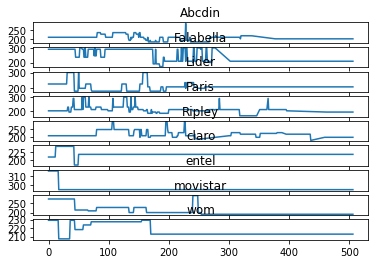

In [4]:
methods= ["linear","time","slinear","quadratic","cubic","barycentric",
        "krogh", "from_derivatives", "pchip", "akima", "cubicspline"]
orders = ["polynomial","spline"]
methods += orders
order = 5

method = methods[2]
#for name in df_wide.columns:
if method in orders:
    df_wide.interpolate(option=method,order=order,inplace=True,limit_direction="both")
else:
    df_wide.interpolate(option=method,inplace=True,limit_direction="both")

i = 1
plt.figure()
for col in df_wide.columns:
    plt.subplot(len(df_wide.columns), 1, i)
    plt.plot(df_wide[col].values)
    plt.title(col)
    i += 1
plt.show()

In [5]:
company = "Abcdin"
raw_seq = df_wide[company]
n_steps = 1 #TEM QUE SER PAR
X, y = split_sequence(raw_seq, n_steps)
percent_train = 0.8
value = int(len(X)*percent_train)
#print(len(X))
X_train = X[:value]
#print(len(X_train))
y_train = y[:value]
X_test = X[value:]
#print(len(X_test))
y_test = y[value:]

SARIMA

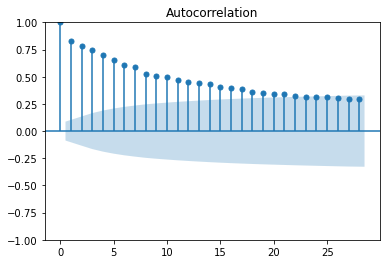

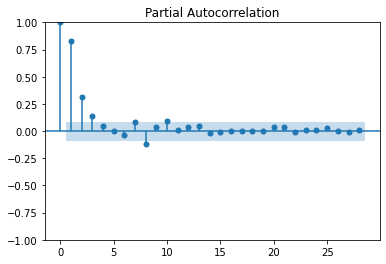

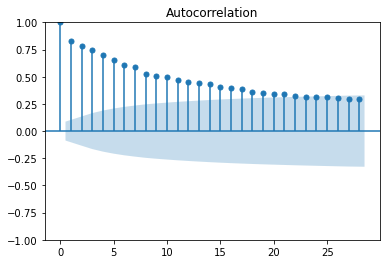

In [6]:

plot_pacf(df_wide[company])
plot_acf(df_wide[company])

ADF Statistic: -3.243957172055529
p-value: 0.017577152295338332


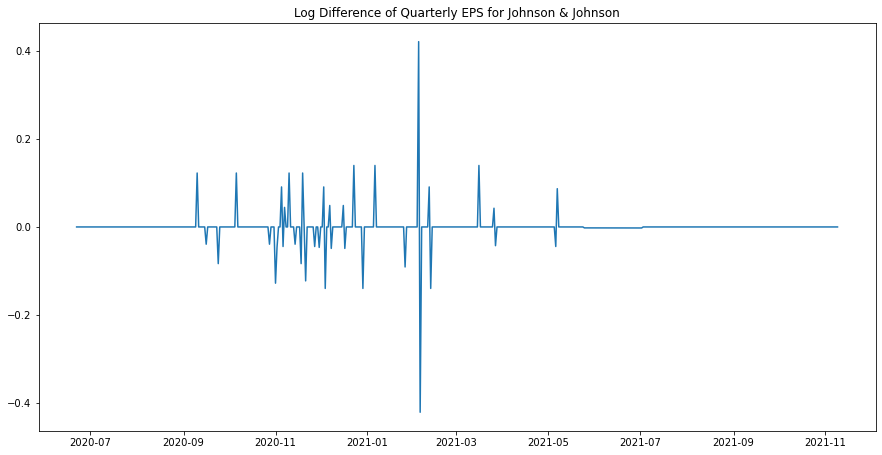

In [7]:
ad_fuller_result = adfuller(df_wide[company])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

df_wide[company] = np.log(df_wide[company])
df_wide[company] = df_wide[company].diff()
df_wide = df_wide.drop(df_wide.index[0])

plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(df_wide[company])
plt.title("Log Difference of Quarterly EPS for Johnson & Johnson")
plt.show()


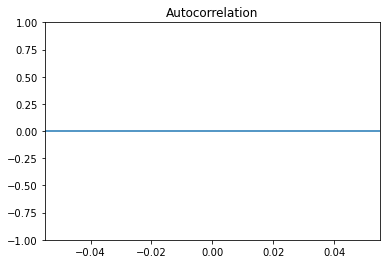

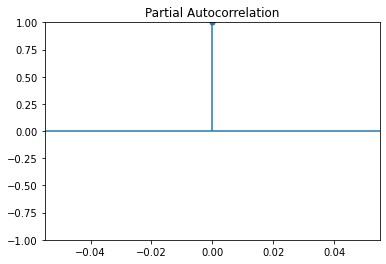

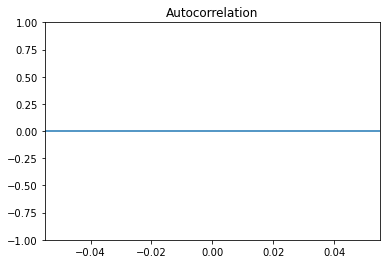

In [10]:
plot_pacf(df_wide[company])
plot_acf(df_wide[company])

In [11]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [12]:

#N sei bem o que fazem estes parametros, mas penso que se pode mudar 

p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [13]:
result_df = optimize_SARIMA(parameters_list, 1, 1, 4, df_wide[company])
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(1, 2, 3, 3)",-1810.444374
1,"(0, 2, 0, 2)",-1810.227101
2,"(0, 3, 0, 2)",-1809.682391
3,"(0, 2, 0, 3)",-1808.838708
4,"(1, 2, 0, 2)",-1808.803138
...,...,...
251,"(2, 0, 0, 0)",-902.724230
252,"(0, 0, 2, 0)",-842.360329
253,"(1, 0, 0, 0)",-750.723330
254,"(0, 0, 1, 0)",-683.224559


In [23]:
best_order = (0, 1, 0)


best_model = SARIMAX(df_wide[company], order=best_order, seasonal_order=(0, 1, 0, 4)).fit(dis=-1)
print(best_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                            Abcdin   No. Observations:                  506
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 4)   Log Likelihood                 238.226
Date:                           Sun, 01 Jan 2023   AIC                           -474.452
Time:                                   22:42:46   BIC                           -470.235
Sample:                               06-22-2020   HQIC                          -472.797
                                    - 11-09-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0199      0.000     79.859      0.000       0.019       0.020
Ljung-Box (L1) (Q):                 216.41 

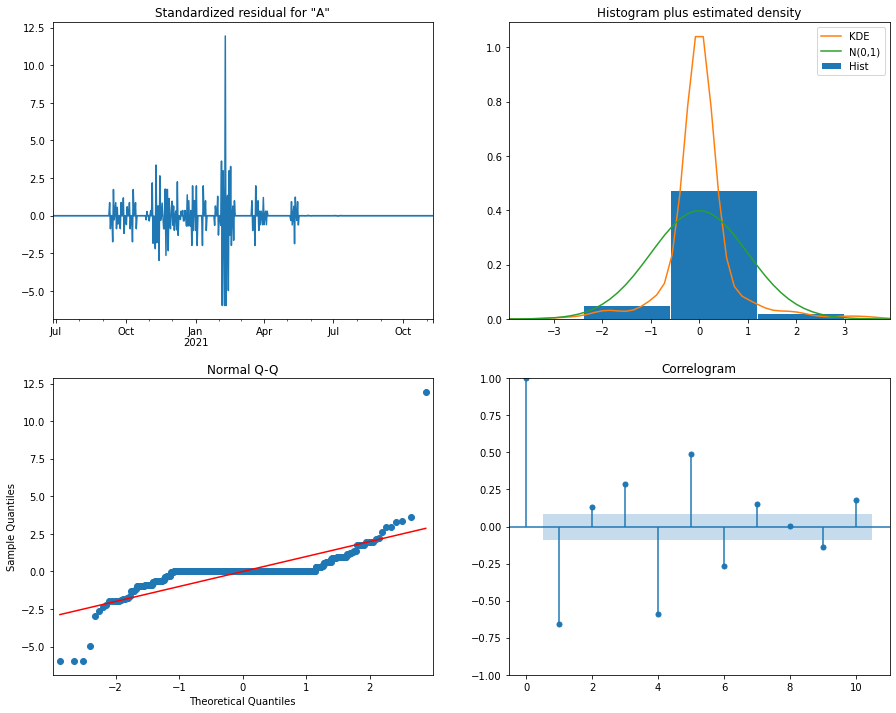

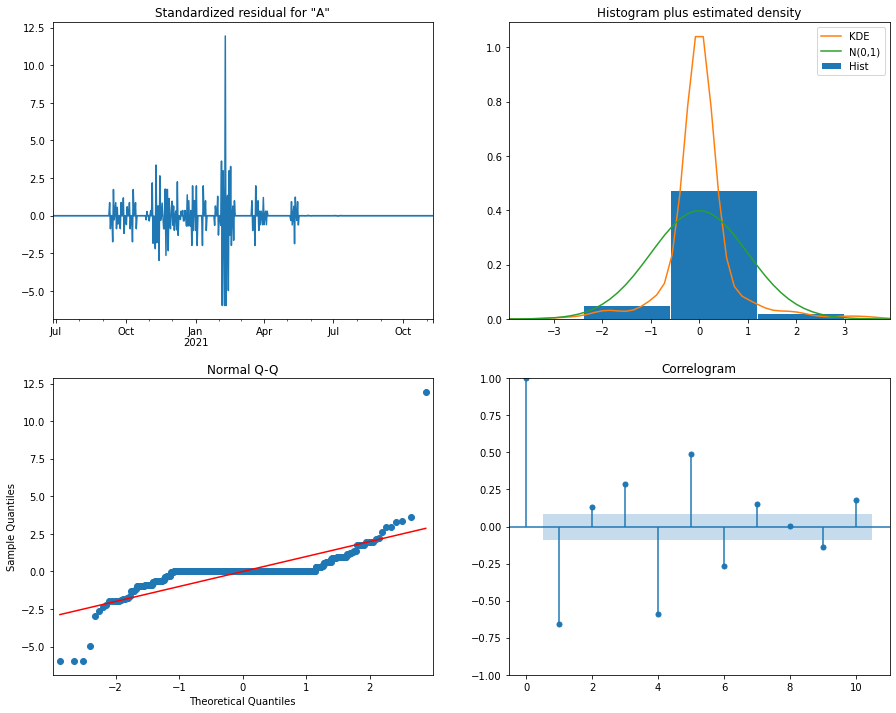

In [24]:
best_model.plot_diagnostics(figsize=(15,12))

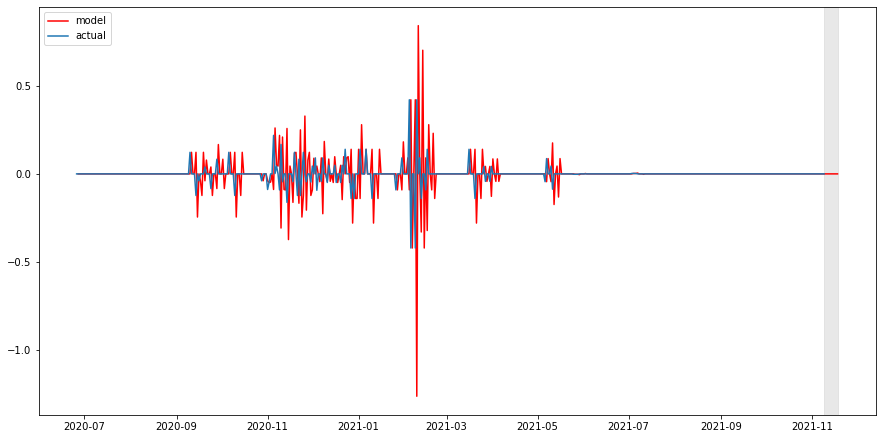

In [25]:
df_wide['arima_model'] = best_model.fittedvalues
df_wide['arima_model'][:4+1] = np.NaN
forecast = best_model.predict(start=df_wide.shape[0], end=df_wide.shape[0] + 8)
forecast = df_wide['arima_model'].append(forecast)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
plt.axvspan(df_wide.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(df_wide[company], label='actual')
plt.legend()
plt.show()